# Boosted Trees for titanic dataset

To facilitate easy comparison with XGBoost I will feed pre-treated numeric-only data into the Boosted trees. As with XGBoost saving and loading the model is part of the exploration

In [1]:
import numpy as np
import pandas as pd

import IPython.display as ipyd

import matplotlib as mpl
import matplotlib.pyplot as pp
import matplotlib.cm as cm
import matplotlib.lines as mpl_ls

import typing as tp

import pickle as pkl

import shutil
import os
import datetime as dt

import sklearn as sk
import sklearn.metrics as sk_mt

import tensorflow as tf
import tensorboard as tb
import tensorflow.keras as tf_ks

import datetime as dt

tf.random.set_seed(42)

#tf.compat.v1.disable_eager_execution()


## Prepare logs directory for tensorboard

In [2]:
LOGS_BASE_DIR = os.path.join(os.path.abspath('.'), 'logs')

try: 
    os.mkdir(LOGS_BASE_DIR) # ok with already-exists errors
except FileExistsError:
    pass

## Load pre-treated data

In [3]:
TRAIN_TEST_PKL_PATH = '../prelims/train_test_data.pkl'

with open(TRAIN_TEST_PKL_PATH, 'rb') as fh: 
    data_dict = pkl.load(fh)
    
TRAIN_DF = data_dict['TRAIN_DF']
TEST_DF = data_dict['TEST_DF']
#
TRAIN_LABEL_SRS = data_dict['TRAIN_LABEL']
TEST_LABEL_SRS = data_dict['TEST_LABEL']

### Feature-spec

Prepare the schema of the data

In [4]:
FEATURE_COLUMNS = []

for feat_name in TRAIN_DF.columns:
    # choose feature type
    val = TRAIN_DF[feat_name].iloc[0]
    
    if type(val) == float or type(val) == np.float or type(val) == np.float16 or type(val) == np.float32 or type(val) == np.float64:
        feat_type = tf.dtypes.float32
    elif type(val) == int or type(val) == np.int or type(val) == np.int16 or type(val) == np.int32 or type(val) == np.int64:
        feat_type = tf.dtypes.int64 # don't use int32 to avoid problems with example-proto's later
    else:
        raise Exception(f'Unexpected feature type for {feat_name}')
        
    # append 
    FEATURE_COLUMNS.append(
        tf.feature_column.numeric_column(
            key=feat_name,
            shape=(1,),
            dtype=feat_type
        )
    )

### Data ingestion

Prepare input function that will serve the data to the estimator as a dataset

In [5]:
def make_input_fn(
    features_df: pd.DataFrame,
    labels_srs: pd.Series,
    repeat_count: tp.Optional[int]=1, # AKA epoch_count
    shuffle: tp.Optional[bool]=False,
    batch_size: tp.Optional[int]=-1 # how many observations go into each batch 
)->tp.Callable[[], tf.data.Dataset]:
    """
    Create and return input_fn. input_fn takes no arguments, and returns dataset with features and labels
    when requested
    
    Arguments:
    ----------
        features_df:  dataframe of the features to be fed into the dataset
        labels_srs:   series to be fed as labels into the dataset
        repeat_count: number of times to repeat the data in the dataset before it ends
                        Can be used to set the number of training epochs. Set to None for forever repeats
        shuffle:      shuffle the data in the dataset
        batch_size:   the number of rows, from the input dataframes, that will be passed as a single record
                          in the output daatset
                          
    Returns:
    --------
        Input funtion
    """
    
    def input_fn()->tf.data.Dataset:
        # create dataset where each record is a tuple with tensor-row from features_df
        # and another tensor with a single value from the corresponding label
        dset = tf.data.Dataset.from_tensor_slices( (dict(features_df), labels_srs) )
        
        if shuffle:
            dset = dset.shuffle(buffer_size=len(labels_srs))
            
        # set number of repeats - useful for train
        dset = dset.repeat(repeat_count)
        
        # batch so that each record contains several rows from the tables
        if batch_size > 0:
            dset = dset.batch(batch_size)
            
        return dset
    
    return input_fn

#### prepare the input functions
TRAIN_INPUT_FN = make_input_fn(TRAIN_DF, TRAIN_LABEL_SRS, repeat_count=None, batch_size=len(TRAIN_DF))
#TEST_INPUT_FN = make_input_fn(TEST_DF, TEST_LABEL_SRS, repeat_count=None, batch_size=len(TEST_DF))

## Train BT

In [6]:
## BT estimator
BT_EST = tf.estimator.BoostedTreesClassifier(FEATURE_COLUMNS, n_batches_per_layer=1)

# set up profiler to record the training process
timestamp_str = dt.datetime.now().strftime('%Y_%m_%dT%H_%M_%S')
PROFILER_DIR = os.path.join(LOGS_BASE_DIR, f'profiler_{timestamp_str}')

tf.profiler.experimental.start(PROFILER_DIR)
#
with tf.profiler.experimental.Trace(f'titanic_bt_train_{timestamp_str}'):
    BT_EST.train(TRAIN_INPUT_FN, max_steps=100)
#
tf.profiler.experimental.stop()

# evaluate result
#BT_RESULT = BT_EST.evaluate(TEST_INPUT_FN)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpbx17tpyw', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and 

## Save model

Serving models goes through `Example` to serialize and deserialze features. I therefore need to prepare feature spec in terms of dicst str->`tf.io.FixedLenFeature`

In [7]:
FEATURE_SPEC_DICT = {
    fc.key: tf.io.FixedLenFeature(shape=fc.shape, dtype=fc.dtype, default_value=fc.default_value)
    for fc in FEATURE_COLUMNS
}

Once we have feature spec in terms of `FixedLenFeature`/`VarLenFeature`, we can use the [`build_parsing_serving_input_receiver_fn`](https://www.tensorflow.org/api_docs/python/tf/estimator/export/build_parsing_serving_input_receiver_fn) to build the `serving_input_receiver_fn`. 

`serving_input_receiver_fn` takes no arguments but returns three outputs designed for lazy evaluation. The first one is a dictionary str->tensor that maps feature names to a specific tensor. The tensor itself is not evaluated, instead it is the output of parsing example-proto contained in the place-holder string tensor. The second output is the string tensor placeholder.

The approach is to call `serving_input_receiver_fn` connect its second output, the placeholder, to the source of example-protibuf strings, and then connect its first output to the model. This will be done by the TF code itself

This will allow building a graph that connects the model directly to the example protobuf strings, thus leading to language-agnotic graph

In [8]:
serving_input_receiver_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(
    FEATURE_SPEC_DICT, #
    default_batch_size=None
)

Prepapre space for the saved model

In [9]:
BT_MODEL_BASE_PATH = os.path.join(os.path.abspath('.'), 'bt_saved_model')
shutil.rmtree(BT_MODEL_BASE_PATH, ignore_errors=True)
os.mkdir(BT_MODEL_BASE_PATH)

Save model

In [10]:
BT_MODEL_PATH = BT_EST.export_saved_model(
    export_dir_base=BT_MODEL_BASE_PATH,
    serving_input_receiver_fn=serving_input_receiver_fn
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: ['serving_default', 'classification']
INFO:tensorflow:Signatures INCLUDED in export for Regress: ['regression']
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from /tmp/tmpbx17tpyw/model.ckpt-100
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:SavedModel wr

## Loading the model

In [11]:
LOADED_EST = tf.saved_model.load(BT_MODEL_PATH)

will need to feed data as examples to the model

In [12]:
def df_row_to_example(
    src_df: pd.DataFrame,
    src_row: int
)->tf.train.Example:
    """
    Given pandas dataframe and row convert it to example_pb2. Tried with series (row at a time) initially, 
    but series tend to make integer-valued features into floating point ones, which then clashes with 
    spec expected by the model (encoded in serving_input_receiver)
    
    arguments:
    ---------
        src_df: source dataframe
        src_row: index of the source row
        
    returns:
    --------
        example protobuf
    """
    
    feature_dict = {}
    
    # go though each value and add it to the example as float or int
    for name in src_df.columns:
        val = src_df[name].iloc[src_row]
        
        if type(val) == float or type(val) == np.float or type(val) == np.float16 or type(val) == np.float32 or type(val) == np.float64:
            float_feature = tf.train.Feature(float_list=tf.train.FloatList(value=[val]))
            feature_dict[name] = float_feature
            
        elif type(val) == int or type(val) == np.int or type(val) == np.int16 or type(val) == np.int32 or type(val) == np.int64:
            int64_feature = tf.train.Feature(int64_list=tf.train.Int64List(value=[val]))
            feature_dict[name] = int64_feature
            
        else:
            print(f'Skipping {name}')

    # convert the dictionary of features to example_pb2 and return
    example_pb = tf.train.Example(features=tf.train.Features(feature=feature_dict))
    #
    return example_pb

Now convert serialized example strings to predictions

In [13]:
# serialize all rows to examples
example_pb2_list = [df_row_to_example(TEST_DF, i_row).SerializeToString() for i_row in range(len(TEST_DF))] 

# predict
pred_res = LOADED_EST.signatures['predict'](tf.constant(example_pb2_list))

# extract as series (so it matches with the rest of the code)
PRED_PROBA_SRS = pd.Series(pred_res['probabilities'].numpy()[:,1])
PRED_PROBA_SRS.name = 'Survived'

plot precision and recall

(-0.05, 1.05)

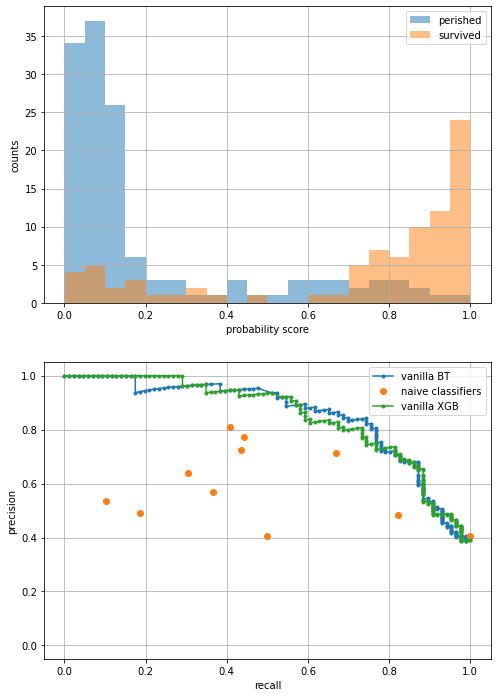

In [14]:
fig, ax = pp.subplots(2, 1, figsize=(8, 12))

bins = np.linspace(0, 1, 21)
#
ax[0].hist(PRED_PROBA_SRS[(TEST_LABEL_SRS==0).values], bins=bins, label='perished', alpha=0.5)
ax[0].hist(PRED_PROBA_SRS[(TEST_LABEL_SRS==1).values], bins=bins, label='survived', alpha=0.5)
ax[0].set_xlabel('probability score')
ax[0].set_ylabel('counts')
ax[0].legend()
ax[0].grid()

# precision-recall curve
precision, recall, thresholds = sk_mt.precision_recall_curve(TEST_LABEL_SRS, PRED_PROBA_SRS)
ax[1].plot(recall, precision, '.-', label='vanilla BT')

# get naive classifiers
NAIVE_CLASSIFIERS_DF = pd.read_pickle('../prelims/naive_precision_recall.pkl')
ax[1].plot(NAIVE_CLASSIFIERS_DF.recall, NAIVE_CLASSIFIERS_DF.precision, 'o', label='naive classifiers')

# get xgboost vanilla results
with open('../XGBoost/vanilla_xgb.pkl', 'rb') as fh:
    XGB_VANILLA_DICT = pkl.load(fh)

xgb_precision, xgb_recall, thresholds = sk_mt.precision_recall_curve(
    XGB_VANILLA_DICT['TEST_LABEL_SRS'],
    XGB_VANILLA_DICT['PRED_PROBA_SRS']
)
ax[1].plot(xgb_recall, xgb_precision, '.-', label='vanilla XGB')
    
ax[1].set_xlabel('recall')
ax[1].set_ylabel('precision')
ax[1].legend()
ax[1].grid()
ax[1].set_xlim([-0.05, 1.05])
ax[1].set_ylim([-0.05, 1.05])

In [20]:
# save precision and recall for comparisons in hyper-parameter tuning

with open('vanilla_precision_recall.pkl', 'wb') as fh:
    i_order = np.argsort(recall)
    pkl.dump({'precision': precision[i_order], 'recall': recall[i_order]}, fh)

## Feature importances

Get feature importances and compare to XGB

In [16]:
with open('../XGBoost/xgb_feature_imp.pkl', 'rb') as fh:
    XGB_feat_imp_dd = pkl.load(fh)

In [17]:
BT_feat_imp_dict = BT_EST.experimental_feature_importances(normalize=True)

In [18]:
feat_imp_dict_list = []

for key in BT_feat_imp_dict.keys():
    feat_imp_dict_list.append({
        'feature': key,
        'xgb_gain': XGB_feat_imp_dd["gain"][key],
        'xgb_weight': XGB_feat_imp_dd["weight"][key],
        'bt_feat_imp': BT_feat_imp_dict[key]
    })
    
FEAT_IMP_DF = pd.DataFrame(feat_imp_dict_list)

# normalize each col to max
FEAT_IMP_DF = FEAT_IMP_DF.assign(
    xgb_gain=lambda old_df: old_df.xgb_gain/old_df.xgb_gain.max(),
    xgb_weight=lambda old_df: old_df.xgb_weight/old_df.xgb_weight.max(),
    bt_feat_imp=lambda old_df: old_df.bt_feat_imp/old_df.bt_feat_imp.max(),
) 

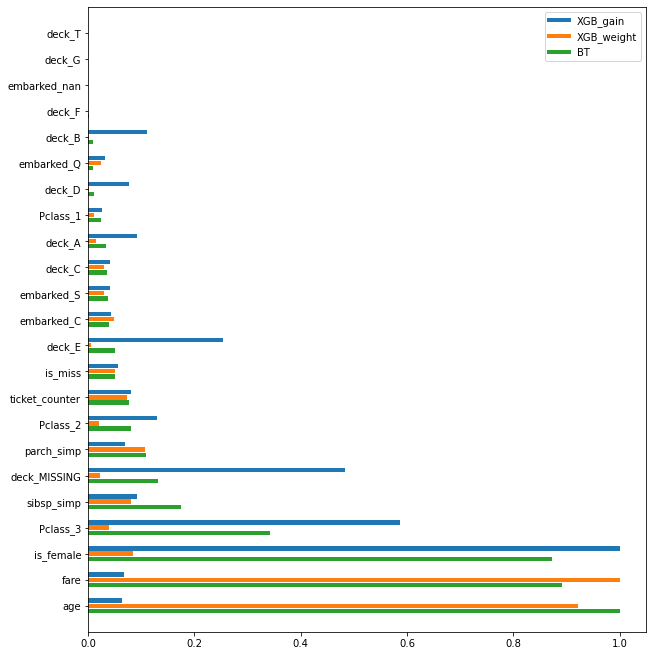

In [19]:
fig, ax = pp.subplots(figsize=(10, 0.5*len(FEAT_IMP_DF)))


spacing = 3
height = 0.5
inter_bar_spacing = 0.6

vert_pos_range = np.arange(0, spacing*len(FEAT_IMP_DF), spacing)

for i_row, (_, row) in enumerate(FEAT_IMP_DF.iterrows()):
    
    ax.barh(vert_pos_range[i_row]+inter_bar_spacing, row.xgb_gain, height=height, color=cm.tab10(0))
    ax.barh(vert_pos_range[i_row], row.xgb_weight, height=height, color=cm.tab10(1))
    ax.barh(vert_pos_range[i_row]-inter_bar_spacing, row.bt_feat_imp, height=height, color=cm.tab10(2))
    
#

ax.set_ylim([vert_pos_range.min()-spacing, vert_pos_range.max()+spacing])
ax.set_yticks(vert_pos_range)
_ = ax.set_yticklabels(FEAT_IMP_DF.feature)

### custom legend
custom_lines = [mpl_ls.Line2D([0], [0], color=cm.tab10(0), lw=4),
                mpl_ls.Line2D([0], [0], color=cm.tab10(1), lw=4),
                mpl_ls.Line2D([0], [0], color=cm.tab10(2), lw=4)]
ax.legend(custom_lines, ['XGB_gain', 'XGB_weight', 'BT'])

It is interesting to not that there are significant differences in feature importances between Boosted Trees and XGB. Could be a good idea to try to combine these models